In [1]:
!pip install pywavelets

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pywt

import os

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip -O dataset.zip

--2023-04-13 14:05:58--  https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60999314 (58M) [application/x-httpd-php]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>]  58.17M  31.2MB/s    in 1.9s    

2023-04-13 14:06:05 (31.2 MB/s) - ‘dataset.zip’ saved [60999314/60999314]



In [3]:
!unzip dataset.zip

Archive:  dataset.zip
   creating: UCI HAR Dataset/
  inflating: UCI HAR Dataset/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/UCI HAR Dataset/
  inflating: __MACOSX/UCI HAR Dataset/._.DS_Store  
  inflating: UCI HAR Dataset/activity_labels.txt  
  inflating: __MACOSX/UCI HAR Dataset/._activity_labels.txt  
  inflating: UCI HAR Dataset/features.txt  
  inflating: __MACOSX/UCI HAR Dataset/._features.txt  
  inflating: UCI HAR Dataset/features_info.txt  
  inflating: __MACOSX/UCI HAR Dataset/._features_info.txt  
  inflating: UCI HAR Dataset/README.txt  
  inflating: __MACOSX/UCI HAR Dataset/._README.txt  
   creating: UCI HAR Dataset/test/
   creating: UCI HAR Dataset/test/Inertial Signals/
  inflating: UCI HAR Dataset/test/Inertial Signals/body_acc_x_test.txt  
   creating: __MACOSX/UCI HAR Dataset/test/
   creating: __MACOSX/UCI HAR Dataset/test/Inertial Signals/
  inflating: __MACOSX/UCI HAR Dataset/test/Inertial Signals/._body_acc_x_test.txt  
  inflating: UCI HAR Dataset

In [2]:
data_dir = "data/UCI HAR Dataset"

def read_data(split):
    global data_dir
    path = os.path.join(data_dir, split, "Inertial Signals")
    files = os.listdir(path)
    files = [
        f'total_acc_z_{split}.txt', f'total_acc_y_{split}.txt', f'total_acc_x_{split}.txt', 
        f'body_acc_z_{split}.txt', f'body_acc_y_{split}.txt',  f'body_acc_x_{split}.txt', 
        f'body_gyro_z_{split}.txt', f'body_gyro_y_{split}.txt', f'body_gyro_x_{split}.txt', 
    ]
    
    X = torch.zeros((7352 if split == "train" else 2947, 9, 128))
    
    for i, file in enumerate(files):
        j = 0 
        with open(os.path.join(path, file), "r") as f:
            content = f.readlines()
            content = list(map(lambda x: x.split(" "), content))

            for line in content:
              X[j, i] = torch.Tensor([float(x) for x in line if x != ""])
              j += 1
    
    with open(os.path.join(data_dir, split, f"y_{split}.txt"), "r") as f:
        content = f.readlines()
        y = np.array(content).astype(float)
                
    return X, torch.tensor(y)

In [3]:
X_train, y_train = read_data(split="train")
val_size = int(0.95 * X_train.size(0))

X_valid, y_valid = X_train[val_size:], y_train[val_size:]
X_train, y_train = X_train[:val_size], y_train[:val_size]
X_test, y_test = read_data(split="test")

X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_valid.shape, y_valid.shape

(torch.Size([6984, 9, 128]),
 torch.Size([6984]),
 torch.Size([2947, 9, 128]),
 torch.Size([2947]),
 torch.Size([368, 9, 128]),
 torch.Size([368]))

In [4]:
def cwt(signal):
    wavelet='cmor0.8-1.5'
    dt = 1 / 2048
    fa = np.arange(1, 129)
    a = pywt.central_frequency(wavelet) / (dt * fa)
    coeff, freqs = pywt.cwt(signal, a, wavelet, dt)
    
    return coeff

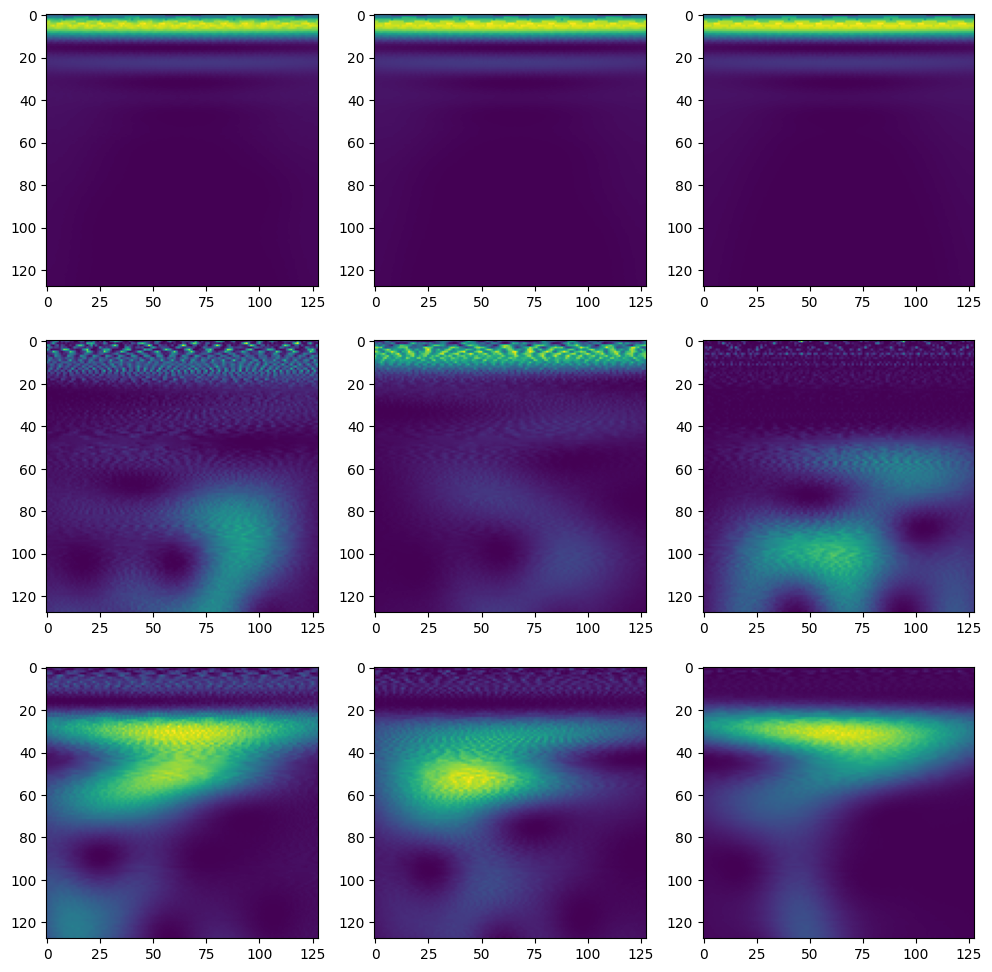

In [5]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for ax, signal in zip(axes.flat, X_train[5]):
    cwt_signal = abs(cwt(signal.numpy())) ** 2
    ax.imshow(cwt_signal)

In [6]:
def process_data(data):
    data_transformed = torch.zeros((*data.shape, 128))
    for i, line in enumerate(data):
        for j, signal in enumerate(line):
          data_transformed[i][j] = torch.Tensor(cwt(signal.numpy()))
        if i % 250 == 0:
            print(f"Processed {(i + 1):4d} / {len(data)}")
    return data_transformed

In [7]:
X_train_transformed = process_data(X_train)
X_valid_transformed = process_data(X_valid)
X_test_transformed = process_data(X_test)

Processed    1 / 6984
Processed  251 / 6984
Processed  501 / 6984
Processed  751 / 6984
Processed 1001 / 6984
Processed 1251 / 6984
Processed 1501 / 6984
Processed 1751 / 6984
Processed 2001 / 6984
Processed 2251 / 6984
Processed 2501 / 6984
Processed 2751 / 6984
Processed 3001 / 6984
Processed 3251 / 6984
Processed 3501 / 6984
Processed 3751 / 6984
Processed 4001 / 6984
Processed 4251 / 6984
Processed 4501 / 6984
Processed 4751 / 6984
Processed 5001 / 6984
Processed 5251 / 6984
Processed 5501 / 6984
Processed 5751 / 6984
Processed 6001 / 6984
Processed 6251 / 6984
Processed 6501 / 6984
Processed 6751 / 6984
Processed    1 / 368
Processed  251 / 368
Processed    1 / 2947
Processed  251 / 2947
Processed  501 / 2947
Processed  751 / 2947
Processed 1001 / 2947
Processed 1251 / 2947
Processed 1501 / 2947
Processed 1751 / 2947
Processed 2001 / 2947
Processed 2251 / 2947
Processed 2501 / 2947
Processed 2751 / 2947


In [8]:
y_train -= 1
y_test -= 1
y_valid -= 1

y_train = torch.Tensor(y_train).long()
y_valid = torch.Tensor(y_valid).long()
y_test = torch.Tensor(y_test).long()

In [9]:
train_dataset = torch.utils.data.TensorDataset(X_train_transformed, y_train)
valid_dataset = torch.utils.data.TensorDataset(X_valid_transformed, y_valid)
test_dataset = torch.utils.data.TensorDataset(X_test_transformed, y_test)

In [10]:
len(train_dataset), len(valid_dataset), len(test_dataset)

(6984, 368, 2947)

In [11]:
torch.save(train_dataset, "train_dataset.pt")
torch.save(valid_dataset, "valid_dataset.pt")
torch.save(test_dataset, "test_dataset.pt")

In [42]:
batch_size = 128

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

len(train_dataloader), len(train_dataloader.dataset), len(valid_dataloader), len(valid_dataloader.dataset), len(test_dataloader), len(test_dataloader.dataset)

(55, 6984, 3, 368, 24, 2947)

In [43]:
class CNN(nn.Module):
  def __init__(self, filters, hidden_units, dropout=0.2):
    super(CNN, self).__init__()
    self.dropout = dropout
    self.conv1 = nn.Conv2d(in_channels=9, out_channels=filters, kernel_size=5)
    self.bn1 = nn.BatchNorm2d(num_features=filters)
    self.conv2 = nn.Conv2d(in_channels=filters, out_channels=32, kernel_size=5)
    self.bn2 = nn.BatchNorm2d(num_features=32)
    self.fc1 = nn.Linear(in_features=32 * 4 * 4, out_features=hidden_units)
    self.fc2 = nn.Linear(in_features=hidden_units, out_features=6)

  def forward(self, x):
    x = self.conv1(x)
    x = F.max_pool2d(x, 5)
    x = self.bn1(F.relu(x))

    x = self.conv2(x)
    x = F.max_pool2d(x, 5)
    x = self.bn2(F.relu(x))

    x = F.dropout(x, 0.1)

    x = torch.flatten(x, start_dim=1)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, self.dropout)
    x = self.fc2(x)

    return F.log_softmax(x, dim=1)  

In [44]:
def validation(model, device, dataloader):
  model.eval()
  model = model.to(device)
  criterion = nn.CrossEntropyLoss()
  with torch.inference_mode():
    avg_loss = 0
    avg_acc = 0
    for X, y in tqdm(dataloader, total=len(dataloader), desc="validation"):
      X, y = X.to(device), y.to(device)
      output = model(X)
      loss = criterion(output, y)
      avg_loss += loss.item()
      avg_acc += (torch.argmax(output, dim=1) == y).float().mean().item()

    avg_acc /= len(dataloader) 
    avg_loss /= len(dataloader)

  model.train()
  return avg_acc, avg_loss

def train_loop(model, dataloader, valid_dataloader, device, epochs, learning_rate=1e-4, momentum=0.9, wd=0, use_scheduler=False):
  model.train()
  model = model.to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=wd, betas=(momentum, 0.999))
  if use_scheduler:
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
  train_losses = []
  val_losses = []
  for epoch in tqdm(range(epochs), desc="training"): 
    curr_loss = 0
    for i, (X, y) in enumerate(dataloader):
      optimizer.zero_grad()
      X, y = X.to(device), y.to(device)
      output = model(X)
      loss = criterion(output, y)
      curr_loss += loss.item()
      loss.backward()
      optimizer.step()
      if i % 50 == 0:
        print(f"[Epoch {(epoch+1):3d}/{epochs:3d}][{i:3d}/{len(dataloader):3d}] train_loss: {loss.item():.6f}")
    if use_scheduler:
      scheduler.step()
    curr_loss /= len(dataloader)
    val_acc, val_loss = validation(model, device, valid_dataloader)
    print(f"[Epoch {(epoch+1):3d}/{epochs:3d}] train_loss: {curr_loss:.6f}, val_loss: {val_loss:.6f}, val_acc: {val_acc:2.6f}")
    train_losses.append(curr_loss)
    val_losses.append(val_loss)
  
  return train_losses, val_losses

In [59]:
torch.manual_seed(12345)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn = CNN(filters=64, hidden_units=128, dropout=0.5).to(device)

train_losses, val_losses = train_loop(model=cnn, dataloader=train_dataloader, valid_dataloader=valid_dataloader,
                                      device=device, epochs=10, learning_rate=7e-5, momentum=0.85, wd=0.09, use_scheduler=False)

training:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch   1/ 10][  0/ 55] train_loss: 1.832435
[Epoch   1/ 10][ 50/ 55] train_loss: 0.703376


training:  10%|█         | 1/10 [00:02<00:24,  2.69s/it]

[Epoch   1/ 10] train_loss: 1.091821, val_loss: 0.707110, val_acc: 0.835193
[Epoch   2/ 10][  0/ 55] train_loss: 0.706648
[Epoch   2/ 10][ 50/ 55] train_loss: 0.412905


training:  20%|██        | 2/10 [00:05<00:21,  2.63s/it]

[Epoch   2/ 10] train_loss: 0.491295, val_loss: 0.368927, val_acc: 0.929315
[Epoch   3/ 10][  0/ 55] train_loss: 0.355450
[Epoch   3/ 10][ 50/ 55] train_loss: 0.294130


training:  30%|███       | 3/10 [00:10<00:25,  3.69s/it]

[Epoch   3/ 10] train_loss: 0.311875, val_loss: 0.294320, val_acc: 0.937500
[Epoch   4/ 10][  0/ 55] train_loss: 0.297041
[Epoch   4/ 10][ 50/ 55] train_loss: 0.245434


training:  40%|████      | 4/10 [00:14<00:22,  3.74s/it]

[Epoch   4/ 10] train_loss: 0.248875, val_loss: 0.230810, val_acc: 0.940104
[Epoch   5/ 10][  0/ 55] train_loss: 0.188311
[Epoch   5/ 10][ 50/ 55] train_loss: 0.221996


training:  50%|█████     | 5/10 [00:17<00:17,  3.57s/it]

[Epoch   5/ 10] train_loss: 0.214019, val_loss: 0.218948, val_acc: 0.924479
[Epoch   6/ 10][  0/ 55] train_loss: 0.182374
[Epoch   6/ 10][ 50/ 55] train_loss: 0.150024


training:  60%|██████    | 6/10 [00:20<00:13,  3.28s/it]

[Epoch   6/ 10] train_loss: 0.199421, val_loss: 0.214828, val_acc: 0.950521
[Epoch   7/ 10][  0/ 55] train_loss: 0.205366
[Epoch   7/ 10][ 50/ 55] train_loss: 0.208010


training:  70%|███████   | 7/10 [00:25<00:12,  4.11s/it]

[Epoch   7/ 10] train_loss: 0.188986, val_loss: 0.193749, val_acc: 0.955729
[Epoch   8/ 10][  0/ 55] train_loss: 0.178272
[Epoch   8/ 10][ 50/ 55] train_loss: 0.176357


training:  80%|████████  | 8/10 [00:28<00:07,  3.62s/it]

[Epoch   8/ 10] train_loss: 0.183753, val_loss: 0.190643, val_acc: 0.932292
[Epoch   9/ 10][  0/ 55] train_loss: 0.177701
[Epoch   9/ 10][ 50/ 55] train_loss: 0.160297


training:  90%|█████████ | 9/10 [00:31<00:03,  3.33s/it]

[Epoch   9/ 10] train_loss: 0.177391, val_loss: 0.169190, val_acc: 0.940104
[Epoch  10/ 10][  0/ 55] train_loss: 0.174299
[Epoch  10/ 10][ 50/ 55] train_loss: 0.175284


training: 100%|██████████| 10/10 [00:33<00:00,  3.39s/it]

[Epoch  10/ 10] train_loss: 0.173885, val_loss: 0.170034, val_acc: 0.955729


validation: 100%|██████████| 24/24 [00:00<00:00, 24.99it/s]


(0.9231770833333334, 0.24300546160278222)

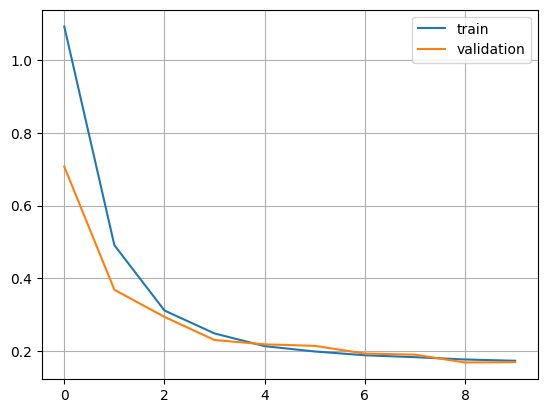

In [60]:
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="validation")
plt.legend()
plt.grid()

validation(cnn, device, test_dataloader)